In [1]:
import torch

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import ignite.metrics as ig

import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
from IPython.display import clear_output

import os
from PIL import Image

import time

In [2]:
teach_im_count = 100
batch_size = 6
begin_offset = 4000

In [3]:
folder_path = 'Orig'

# Получите список файлов в папке
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Инициализируйте список для хранения массивов изображений
image_arrays = []
# Загрузите каждое изображение, преобразуйте его в массив и добавьте в список
for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    if i >= begin_offset:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            image_arrays.append(image_array)
    if i == teach_im_count + begin_offset - 1:
        break
# Преобразуйте список массивов в один numpy массив
orig_array = np.array(image_arrays)

print(orig_array.shape)

folder_path = 'Record'

# Получите список файлов в папке
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
#print(image_files)
# Инициализируйте список для хранения массивов изображений
image_arrays = []

for i, image_file in enumerate(image_files):
    image_path = os.path.join(folder_path, image_file)
    if i >= begin_offset:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            image_arrays.append(image_array)
        if i % 1000 == 0:
            print(i - begin_offset)
    if i == teach_im_count + begin_offset - 1:
        break
    
record_array = np.array(image_arrays)

print(record_array.shape)

class OrigDataset(Dataset):
    def __init__(self, x):
        self.orig_transform = transforms.Compose([
            transforms.ToTensor()
        ])
        self.x = x
         
    def __len__(self):
        return len(self.x)
        
    def __getitem__(self, idx):
        x = self.orig_transform(self.x[idx])
        return x
        
class ImDataset(Dataset):
    def __init__(self, x_arr, y_arr):
        self.orig_transform = transforms.Compose([
            transforms.ToTensor()
        ])
        self.rec_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((420, 420))
        ])
        
        self.x = x_arr
        self.y = y_arr
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        
        x = self.orig_transform(self.x[idx])
        y = self.rec_transform(self.y[idx])
        return x, y
        
dataset = ImDataset(orig_array, record_array)
dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
orig_array = None
record_array = None

(100, 420, 420, 3)
0
(100, 700, 700, 3)


In [4]:
def show_images(orig, record, size):

  f, axes = plt.subplots(2, size, figsize = (30, 10))
  for i, ax in enumerate(axes.ravel()):
    if i < size:
        image = orig[i].detach().numpy()
        image = image.transpose((1, 2, 0))
        ax.imshow(image)
    else:
        image = record[i - size].detach().numpy()
        image = image.transpose((1, 2, 0))
        ax.imshow(image)
  plt.show()

In [13]:
t = torch.zeros(1, 3, 20, 20)

In [7]:
print(t.shape)

torch.Size([1, 3, 20, 20])


In [19]:
t = torch.rand(1, 3, 420, 420)

In [18]:
t

tensor([[[[0.9862, 0.0462, 0.3274, 0.0032],
          [0.3002, 0.2631, 0.3727, 0.0742],
          [0.5042, 0.4497, 0.2435, 0.4558],
          [0.4750, 0.0905, 0.0170, 0.6566]],

         [[0.8309, 0.9055, 0.1316, 0.4628],
          [0.0853, 0.0854, 0.4004, 0.8453],
          [0.1110, 0.2360, 0.1667, 0.1752],
          [0.4925, 0.0822, 0.1830, 0.7535]]]])

In [16]:
t[:, 0:1,:,:]

tensor([[[[0.9862, 0.0462, 0.3274, 0.0032],
          [0.3002, 0.2631, 0.3727, 0.0742],
          [0.5042, 0.4497, 0.2435, 0.4558],
          [0.4750, 0.0905, 0.0170, 0.6566]]]])

In [17]:
t[:, 1:2,:,:]

tensor([[[[0.8309, 0.9055, 0.1316, 0.4628],
          [0.0853, 0.0854, 0.4004, 0.8453],
          [0.1110, 0.2360, 0.1667, 0.1752],
          [0.4925, 0.0822, 0.1830, 0.7535]]]])

In [20]:
t = torch.tensor(0)
for batch in dataloader:
    x, y = batch
    t = x
    break

In [17]:
t = t

In [21]:
t.shape

torch.Size([6, 3, 420, 420])

In [22]:
s = t.unfold(1, 105, 105)
s = s.unfold(2, 105, 105)
s.shape

RuntimeError: maximum size for tensor at dimension 1 is 3 but size is 105

torch.Size([3, 5, 5, 84, 84])

In [ ]:
show_images(s[],patching(t, 84), 10)

In [23]:
m = s.contiguous().view(-1, 3, 105, 105)
m = s.transpose(0, 1)
m = m.transpose(1, 2)
m.shape

NameError: name 's' is not defined

In [26]:
t.shape

torch.Size([6, 3, 420, 420])

In [24]:
def make_patches(tensor, in_size, out_size):
    patches_count = (in_size // out_size) ** 2
    parts = tensor.unfold(2, out_size, out_size).unfold(3, out_size, out_size)
    print(parts.shape)
    parts = parts.contiguous().view(batch_size, 3, -1, out_size, out_size)
    parts = parts.transpose(1, 2)
    return parts

In [25]:
a = make_patches(t, 105, 105)
print(a.shape)

torch.Size([6, 3, 4, 4, 105, 105])
torch.Size([6, 16, 3, 105, 105])


In [122]:
a[0].shape

torch.Size([16, 3, 105, 105])

In [29]:
s = a.view(6, 4, 4, 3, 105, 105)
s = s.permute(0, 3, 1, 4, 2, 5)

In [31]:
s = s.contiguous().view(6, 3, 420, 420)

In [32]:
s.shape

torch.Size([6, 3, 420, 420])

In [124]:
a[0][1] = torch.rand((3, 105, 105))

In [5]:
def collect_patches(tensor, in_size, out_size):
    layer_size = out_size // in_size
    t = tensor[:, 0, :, :, :]
    
    for j in range(1, layer_size):
            t = torch.cat((t, tensor[:, j, :, :, :]), dim = 3)
    t_line = t.contiguous()
    
    for i in range(1, layer_size):
        t = tensor[:, i * layer_size, :, :, :] # i *
        for j in range(1, layer_size):
            t = torch.cat((t, tensor[:, i * layer_size + j, :, :, :]), dim = 3).contiguous()
        t_line = torch.cat((t_line, t), dim = 2)

    return t_line

In [36]:
def collect_patches_better(tensor, in_size, out_size):
    layer_size = out_size // in_size
    t = tensor.view(batch_size, layer_size, layer_size, 3, in_size, in_size)
    t = t.permute(0, 3, 1, 4, 2, 5)
    t = t.contiguous().view(batch_size, 3, out_size, out_size)
    return t

In [37]:
p = collect_patches_better(a, 105, 420)

In [38]:
p.shape

torch.Size([6, 3, 420, 420])

In [119]:
p[0, :, :, :] = torch.rand((3, 420, 420))

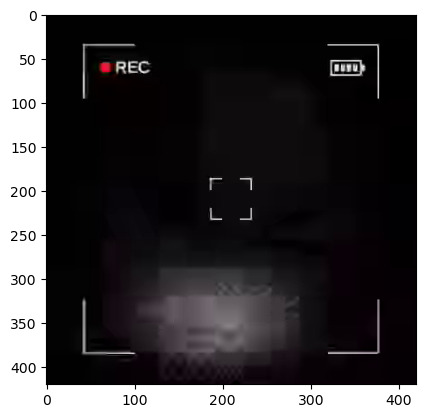

In [43]:
plt.imshow(p[5].detach().numpy().transpose((1,2,0)))

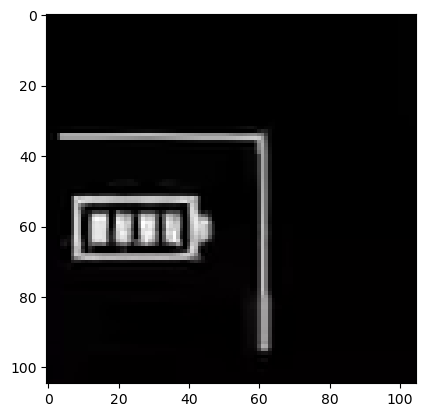

In [67]:
plt.imshow(a[0][3].detach().numpy().transpose((1,2,0)))

torch.Size([10, 10, 3, 42, 42])

In [117]:
m = m.contiguous().view(16, 3, 105, 105)

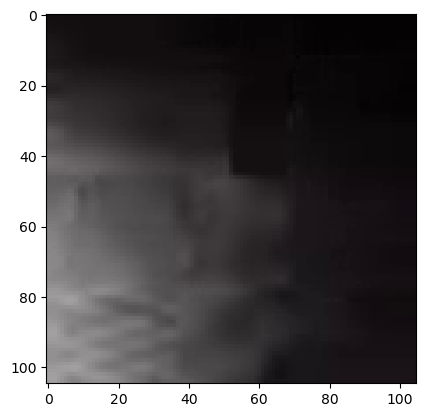

In [120]:
plt.imshow(m[11].detach().numpy().transpose((1,2,0)))

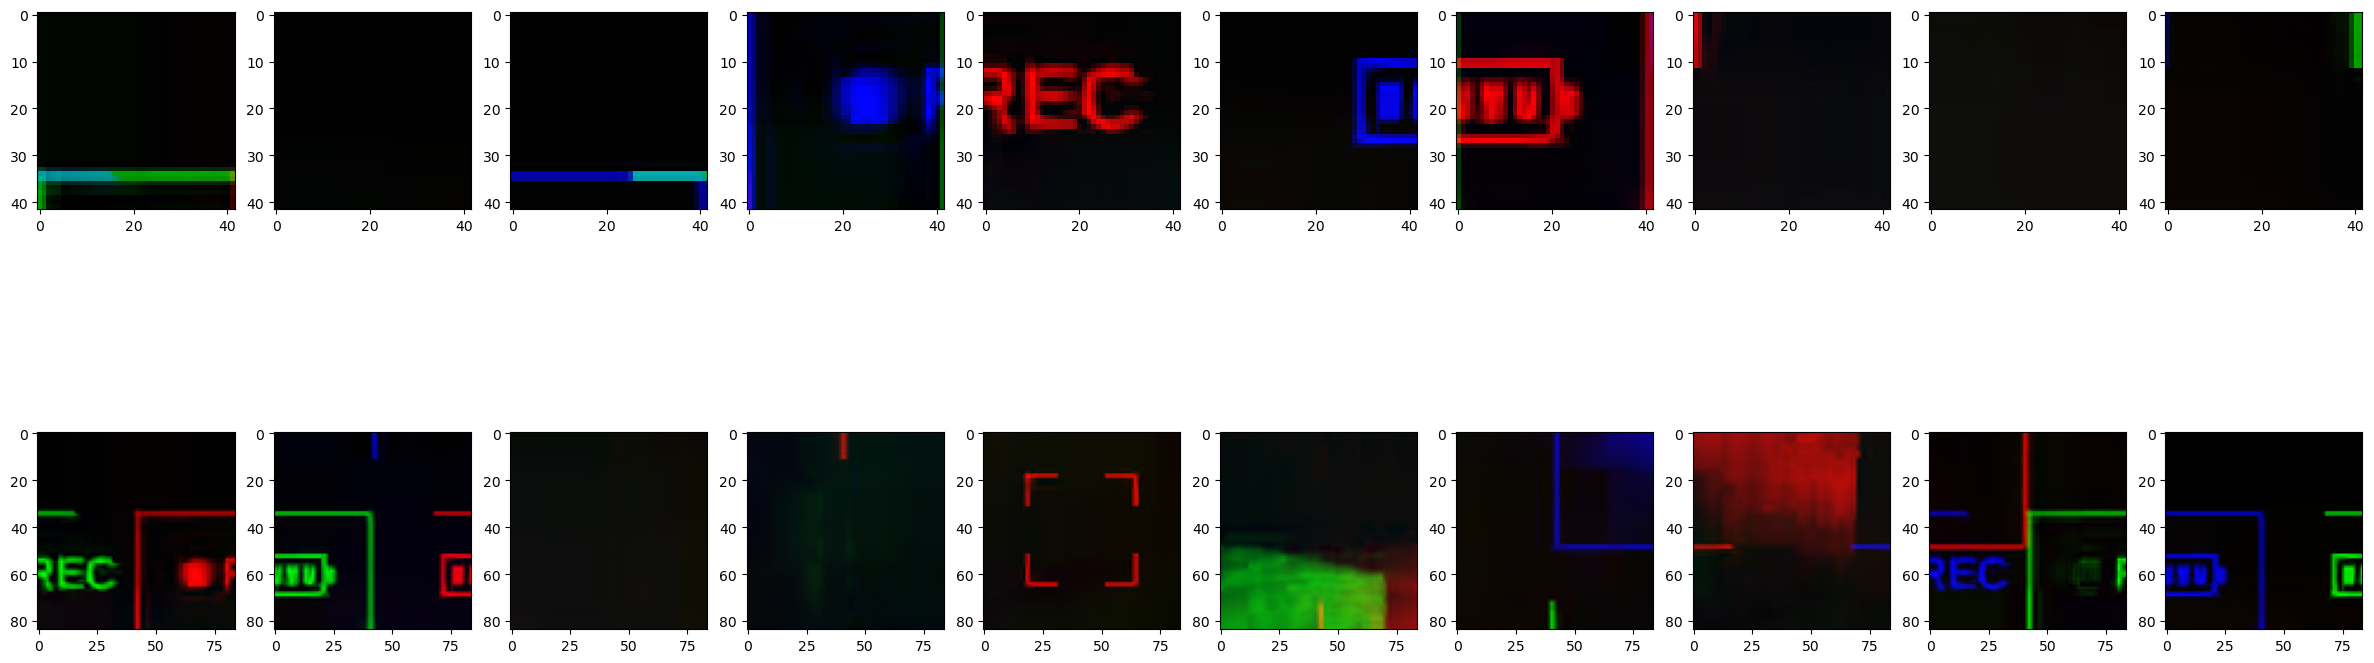

In [36]:
show_images(patching(t, 84),patching(t, 84), 10)

In [35]:
def patching(tensor, patch_size):
    t = tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    t = t.contiguous().view(-1, 3, patch_size, patch_size)
    return t

In [47]:
sp = t.split(42, 1)

(tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ...,

In [1]:
import math
def r(n, k):
    if n >= k:
        return(3**k)
    sum1 = 0
    for i in range(n):
        sum1 += math.comb(k-1, i) * 2**i
    sum2 = 0
    for j in range(n,k - 1):
        sum2 += math.comb(j, n - 1)
    s = 2 * k + 3 * sum1 + 2 ** n * sum2
    return(s)

In [6]:
r(42 * 42 * 3, 10)

59049

In [173]:
import random
exp_count = 100000
it_count = 0
for i in range(exp_count):
    money = 200
    bet = 1
    iterations = 0 
    while money > 0:
        iterations += 1
        n_bet = bet
        while True:
        #print(money)
            r = random.randint(0,2)
            money -= n_bet
            if money <= 0:
                break
            if r == 1:
                money += n_bet * 2
                break
            n_bet *= 2
    it_count += iterations
print(it_count / exp_count)

17.3323


In [ ]:
money = 200
bet = 1
iterations = 0 
while money > 0:
    iterations += 1
    n_bet = bet
    while True:
        #print(money)
        r = random.randint(0,2)
        money -= n_bet
        if money <= 0:
            break
        if r == 1:
            money += n_bet * 2
            break
        n_bet *= 2
print(f"iter: {iterations}")    